# M6.19 Titanic: Machine Learning Disaster 
### Group 4 - Baseline Submission
#### Team Members:
* Marc Mahanna,
* Nicholas Vitellaro,
* Makenna Owens,
* Jonathan Wang

In [26]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [27]:
# Load Data
# train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data = pd.read_csv("../Data/train.csv")
# displaying first 5 rows of the dataset
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
# test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data = pd.read_csv("../Data/test.csv")
# displaying first 5 rows of the test dataset
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [29]:
# Feature Engineering
Pclass2Cabin = {1: 'C', 2: 'E', 3: 'F'}


def pclass2cabin(pclass, cabin):
    if type(cabin) is str:
        ret = cabin[0]
    elif math.isnan(cabin):
        ret = Pclass2Cabin[pclass]
    else:
        ret = 'A'
    return ord(ret)


train_data['CabinLtr'] = train_data.apply(lambda row: pclass2cabin(row['Pclass'], row['Cabin']), axis=1)
test_data['CabinLtr'] = test_data.apply(lambda row: pclass2cabin(row['Pclass'], row['Cabin']), axis=1)

# Fill missing values for 'Age' with median, 'Embarked' with mode, and 'Fare' with median
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)

train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
test_data['Embarked'].fillna(test_data['Embarked'].mode()[0], inplace=True)

train_data['Fare'].fillna(train_data['Fare'].median(), inplace=True)
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)

# Convert categorical features and engineer new features
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch']
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch']

# Standardize numerical features for better model performance
scaler = StandardScaler()
train_data[['Age', 'Fare', 'FamilySize']] = scaler.fit_transform(train_data[['Age', 'Fare', 'FamilySize']])
test_data[['Age', 'Fare', 'FamilySize']] = scaler.transform(test_data[['Age', 'Fare', 'FamilySize']])

/var/folders/y5/54wq6fj15m90x1g7cxplt8hr0000gn/T/ipykernel_27204/849179080.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
/var/folders/y5/54wq6fj15m90x1g7cxplt8hr0000gn/T/ipykernel_27204/849179080.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

In [30]:
# Select features and one-hot encode categorical variables
features_train = ["Survived", "Pclass", "Sex", "SibSp", "Parch", "Fare", "FamilySize", "Embarked", "CabinLtr"]
# features_train = ["Survived", "Pclass", "Sex", "Fare"]
features_test = features_train[1:]
X = pd.get_dummies(train_data[features_train], drop_first=True)
X_test = pd.get_dummies(test_data[features_test], drop_first=True)
y = train_data["Survived"]

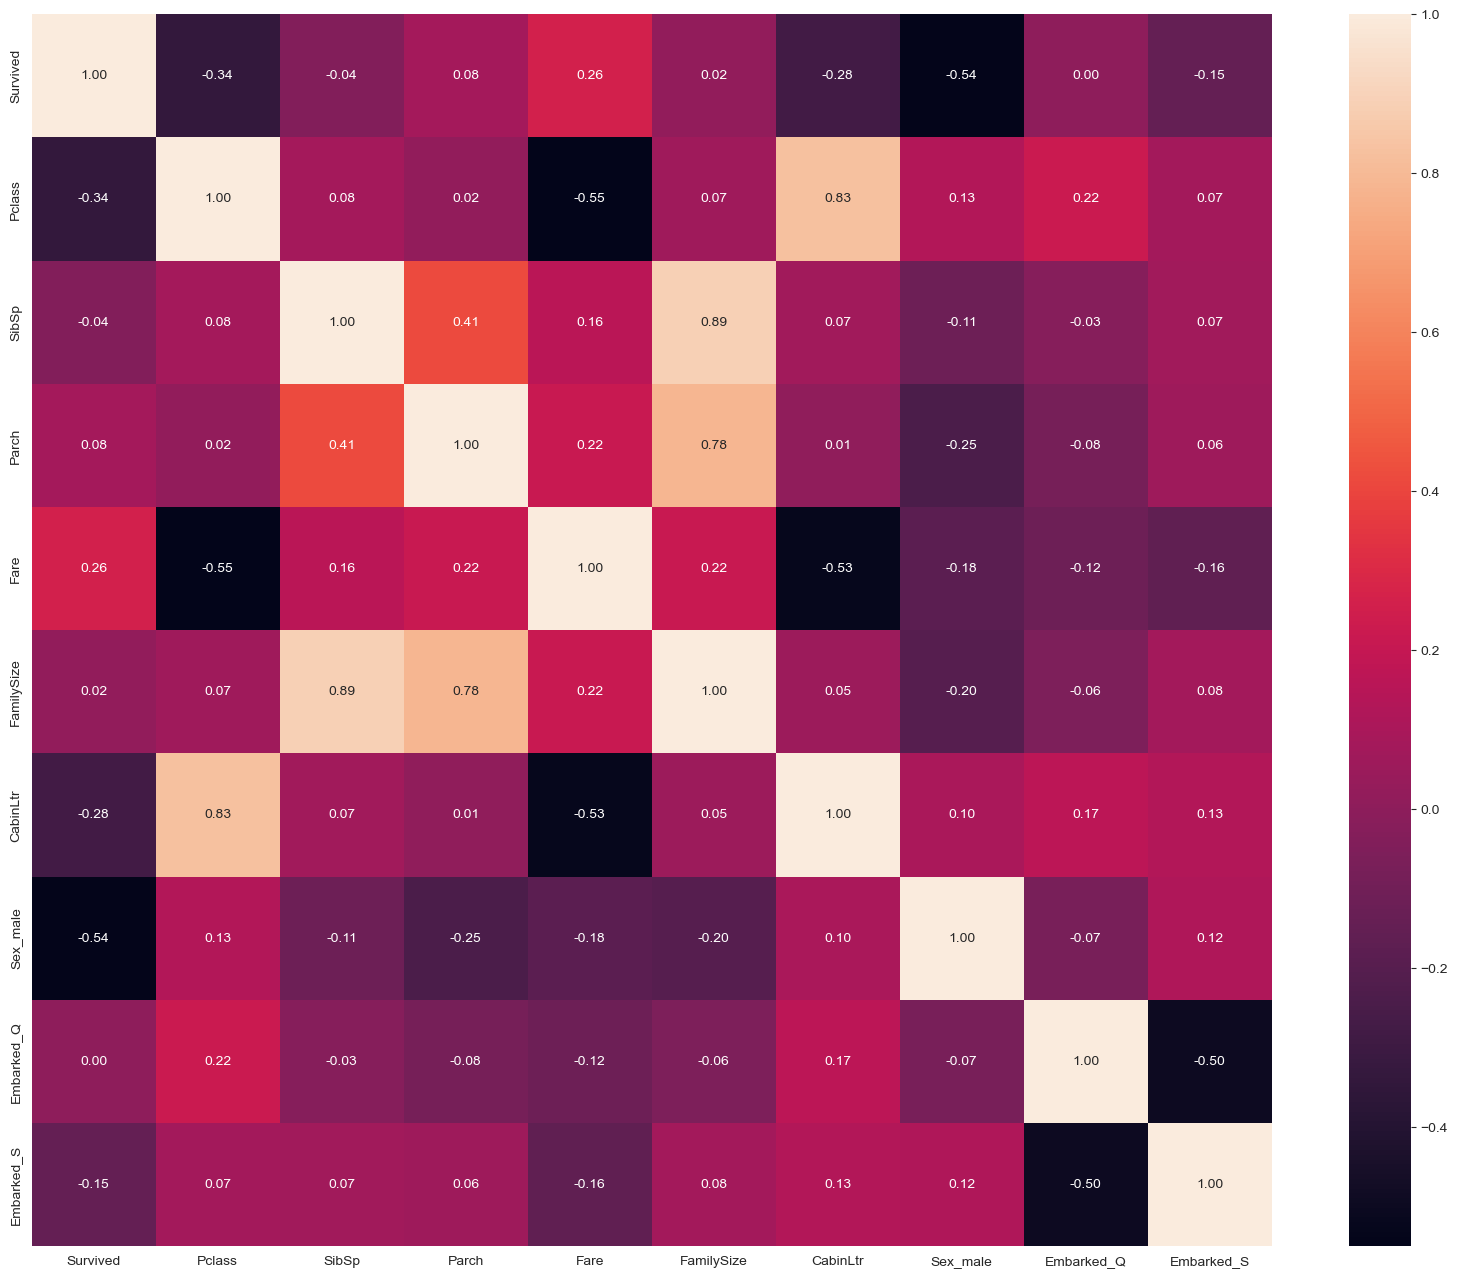

--------------------
Survived      1.000000
Pclass       -0.338481
SibSp        -0.035322
Parch         0.081629
Fare          0.257307
FamilySize    0.016639
CabinLtr     -0.279332
Sex_male     -0.543351
Embarked_Q    0.003650
Embarked_S   -0.149683
Name: Survived, dtype: float64
--------------------
Survived     -0.338481
Pclass        1.000000
SibSp         0.083081
Parch         0.018443
Fare         -0.549500
FamilySize    0.065997
CabinLtr      0.827047
Sex_male      0.131900
Embarked_Q    0.221009
Embarked_S    0.074053
Name: Pclass, dtype: float64
--------------------
Survived     -0.035322
Pclass        0.083081
SibSp         1.000000
Parch         0.414838
Fare          0.159651
FamilySize    0.890712
CabinLtr      0.071013
Sex_male     -0.114631
Embarked_Q   -0.026354
Embarked_S    0.068734
Name: SibSp, dtype: float64
--------------------
Survived      0.081629
Pclass        0.018443
SibSp         0.414838
Parch         1.000000
Fare          0.216225
FamilySize    0.783111


In [31]:
#Get the correlation matrix for the train_dataset
corr_matrix = X.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", annot_kws={'size': 10})
plt.show()
for feature in corr_matrix.columns:
    print('--------------------')
    print(corr_matrix[feature])

In [32]:
X = X.drop(['Survived'], axis=1)

In [33]:
# param_grid = {'learning_rate': [0.01, 0.1, 0.15, 0.2], 'min_samples_leaf': [1, 2, 4], 'max_depth': [7, 9, 11, 13, 15],
#               'max_features': [40, 60, 80, 100], 'n_estimators': [100, 500, 1300, 2300]}
# grid_search = GridSearchCV(GradientBoostingClassifier(random_state=1),
#                            param_grid,
#                            cv=5,
#                            scoring='accuracy',
#                            verbose=3,
#                            n_jobs=-1)
# grid_search.fit(X, y)
# 
# model = grid_search.best_estimator_
# score = grid_search.best_score_
# params = grid_search.best_params_
# print("Best score is: ", score)
# print("Best params are: ", params)

model = GradientBoostingClassifier()
# model = GradientBoostingClassifier(learning_rate=0.01, max_depth=7, max_features=40, min_samples_leaf=2, n_estimators=100)
model.fit(X, y)
model_cv_score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
print("Best score is: ", model_cv_score)

Best score is:  0.7991337643587972


In [34]:
# making predictions on test dataset
predictions = model.predict(X_test)

In [35]:
# creating df with survival predictions
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})

# saving output to csv 
output.to_csv('submission-gbc.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
